In [1]:
# importa e instala o SimPEG - Célula exclusiva para execução em ambiente remoto

# baseado no exemplo em https://docs.simpeg.xyz/content/tutorials/03-gravity/plot_1a_gravity_anomaly.html#sphx-glr-content-tutorials-03-gravity-plot-1a-gravity-anomaly-py

# !git clone https://github.com/simpeg/simpeg
# %cd simpeg
# !pip install -r requirements.txt
# !python setup.py install

import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc

from SimPEG.utils import plot2Ddata, model_builder, surface2ind_topo
from SimPEG import maps
from SimPEG.potential_fields import gravity

In [25]:
class modelo():
    
    """
    Define as dimensões, topografia e malha de tensores do modelo
    """
    
    def __init__(self, par_x, par_y, par_z, rho_bg=0.0, topografia=None):
        
        """
        par_x:    parâmetros de comprimento e discretização do eixo x do modelo
        par_y:    parâmetros de comprimento e discretização do eixo y do modelo
        par_z:    parâmetros de comprimento e discretização do eixo z do modelo
        rho_bg:   densidade do background homogêneo
        """
        
        # cria os eixos x, y e z do modelo
        self.xx_m = np.linspace(-1 * par_x[0]/2, par_x[0]/2, 1 + int(par_x[0]/par_x[1]))
        self.yy_m = np.linspace(-1 * par_y[0]/2, par_y[0]/2, 1 + int(par_y[0]/par_y[1]))
        self.zz_m = np.linspace(0.0, par_z[0], 1 + int(par_z[0]/par_z[1]))
        
        
        # densidade das rochas do background
        self.densidade_background = rho_bg
        
        
        # Define a topografia do modelo
        [x_topo, y_topo] = np.meshgrid(self.xx_m, self.yy_m)
        if topografia=='default':
            z_topo = -15.0 * np.exp(-(x_topo ** 2 + y_topo ** 2) / 80 ** 2)

        elif not topografia:
            z_topo = np.zeros((len(self.yy_m), len(self.xx_m)))

        x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
        self.xyz_topo = np.c_[x_topo, y_topo, z_topo]


        # Define a malha de tensores em células de tamanho regular
        dx = self.xx_m[1]-self.xx_m[0]
        dy = self.yy_m[1]-self.yy_m[0]
        dz = self.zz_m[1]-self.zz_m[0]

        nx = int((np.max(self.xx_m)-np.min(self.xx_m))/dx)
        ny = int((np.max(self.yy_m)-np.min(self.yy_m))/dy)
        nz = int((np.max(self.zz_m)-np.min(self.zz_m))/dz)

        hx = [(dx, nx)]
        hy = [(dy, ny)]
        hz = [(dz, nz)]

        self.mesh = TensorMesh([hx, hy, hz], 'CCN')
        
        # Find the indices for the active mesh cells (e.g. cells below surface)
        self.ind_active = surface2ind_topo(self.mesh, self.xyz_topo)

        # Define mapping from model to active cells. The model consists of a value for
        # each cell below the Earth's surface.
        nC = int(self.ind_active.sum())
        self.model_map = maps.IdentityMap(nP=nC)

        # Define o modelo com a densidade do background. Models in SimPEG are vector arrays.
        self.model = self.densidade_background * np.ones(nC)
        
        
    def insere_esfera(self, rho, coordenadas, raio):
        ind_sphere = model_builder.getIndicesSphere(coordenadas, raio, self.mesh.gridCC)
        ind_sphere = ind_sphere[self.ind_active]
        self.model[ind_sphere] = rho
    
    
    def plota_corte(self, direcao, posicao):

        if direcao.upper()=='X':
            indice_slice = np.abs(posicao - self.xx_m).argmin()
        
        if direcao.upper()=='Y':
            indice_slice = np.abs(posicao-self.yy_m).argmin()
            
        if direcao.upper()=='Z':
            indice_slice = np.abs((np.max(self.zz_m)-np.abs(posicao))-self.zz_m).argmin()
        
        fig = plt.figure(figsize=(15, 5))
        plotting_map = maps.InjectActiveCells(self.mesh, self.ind_active, np.nan)

        ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
        
        self.mesh.plot_slice(
            plotting_map * self.model,
            normal=direcao,
            ax=ax1,
            ind=int(indice_slice),
            grid=True,
            clim=(np.min(self.model), np.max(self.model)),
            pcolorOpts={"cmap": "viridis"},
        )
        ax1.set_title('Corte em ' + direcao.upper() + ' = ' + str(posicao) + ' m')
        
        if direcao=='Y':
            ax1.set_xlabel('Distância em X (m)', fontsize=14)
            ax1.set_ylabel('Profundidade (m)', fontsize=14)
            
        elif direcao=='X':
            ax1.set_xlabel('Distância em Y (m)', fontsize=14)
            ax1.set_ylabel('Profundidade (m)', fontsize=14)
            
        elif direcao=='Z':
            ax1.set_xlabel('Distância em X (m)', fontsize=14)
            ax1.set_ylabel('Distância em Y (m)', fontsize=14)

        ax2 = fig.add_axes([0.85, 0.12, 0.025, 0.78])
        norm = mpl.colors.Normalize(vmin=np.min(self.model), vmax=np.max(self.model))
        cbar = mpl.colorbar.ColorbarBase(
            ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
        )
        cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

        plt.show()

        
class aquisicao():
    
    def __init__(self, xx_s, yy_s, h_s, mod, componente='gz'):
    
        """
        Configura os pontos do levantamento no modelo
        
        The user only needs an (N, 3) array to define the xyz locations of the observation locations, 
        and a list of field components which are to be measured.
        
        xx_s:    coordenadas x dos pontos de levantamento
        yy_s:    coordenadas y dos pontos de levantamento
        h_s:     elevação do levantamento
        mod:     objeto da classe modelo
        """

        x, y = np.meshgrid(xx_s, yy_s)

        x = mkvc(x.T)
        y = mkvc(y.T)

        # cria a função de interpolação para o espaço do modelo
        fun_interp = LinearNDInterpolator(np.c_[mod.xyz_topo[0], mod.xyz_topo[1]], mod.xyz_topo[2])

        # interpola as coordenadas das estações e coloca 5.0 m acima da superfície
        z = fun_interp(np.c_[x, y]) + 5.0

        self.receiver_locations = np.c_[x, y, z]

        # Use the observation locations and components to define the receivers. To
        # simulate data, the receivers must be defined as a list.
        receiver_list = gravity.receivers.Point(self.receiver_locations, components=componente)
        self.receiver_list = [receiver_list]

        # Defining the source field.
        self.source_field = gravity.sources.SourceField(receiver_list=self.receiver_list)

        # Defining the survey
        self.survey = gravity.survey.Survey(self.source_field)    # é um objeto
        
        
    def fwd(self, mod):
        
        # Define the forward simulation. By setting the 'store_sensitivities' keyword
        # argument to "forward_only", we simulate the data without storing the sensitivities
        simulation = gravity.simulation.Simulation3DIntegral(
                        survey = self.survey,
                        mesh = mod.mesh,
                        rhoMap = mod.model_map,
                        actInd = mod.ind_active,
                        store_sensitivities = "forward_only",
        )

        # Compute predicted data for some model
        self.dpred = simulation.dpred(mod.model)
        
        
        
        
        
        

### O usuario configura o modelo aqui.

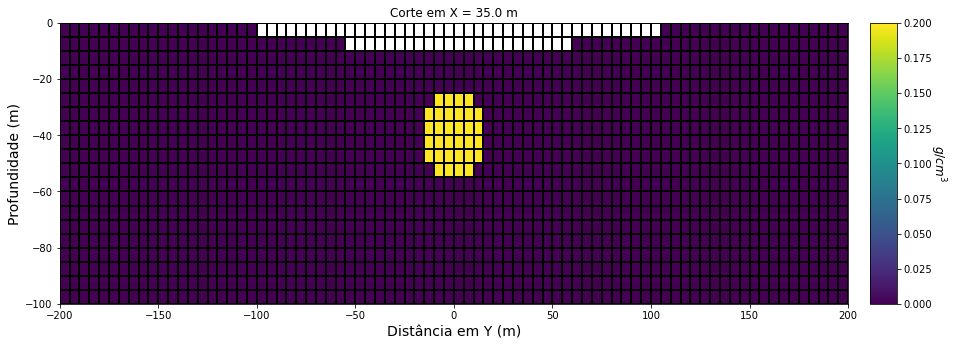

In [26]:
eixo_x = [400.0, 5.0]      # [comprimento, delta]
eixo_y = [400.0, 5.0]      # [comprimento, delta]
eixo_z = [100.0, 5.0]      # [comprimento, delta]

meu_modelo = modelo(eixo_x, eixo_y, eixo_z, topografia='default')
meu_modelo.insere_esfera(0.2, [35.0, 0.0, -40.0], 15.0)

meu_modelo.plota_corte('X', 35.0)

### O usuario configura a aquisição aqui

In [27]:
x_rx = np.linspace(-80.0, 80.0, 17)
y_rx = np.linspace(-80.0, 80.0, 17)
h_rx = 5.0

minha_aquisicao = aquisicao(x_rx, y_rx, h_rx, meu_modelo)

In [28]:
minha_aquisicao.fwd(meu_modelo)

In [ ]:
# Define the forward simulation. By setting the 'store_sensitivities' keyword
# argument to "forward_only", we simulate the data without storing the sensitivities
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=model_map,
    actInd=ind_active,
    store_sensitivities="forward_only",
)

# Compute predicted data for some model
dpred = simulation.dpred(model)

# Plot
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(receiver_list[0].locations, dpred, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly (Z-component)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.82, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()